In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import tree
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
sns.set(color_codes=True)

In [2]:
# Load dataset into a pandas dataframe
df = pd.read_excel('./data/kimchi_dataset.xlsx')
df

,Date,Price,Total Volume,Total Boxes,Small Boxes,Large Boxes,XLarge Boxes,Region
0,2018-03-25,1.71,2321.82,2006.46,1996.46,10.00,0.0,Seoul
1,2018-03-18,1.66,3154.45,2580.60,2577.27,3.33,0.0,Seoul
2,2018-03-11,1.68,2570.52,2209.29,2209.29,0.00,0.0,Seoul
3,2018-03-04,1.48,3851.30,3242.98,3239.65,3.33,0.0,Seoul
4,2018-02-25,1.56,5356.63,4007.48,4007.48,0.00,0.0,Seoul
...,...,...,...,...,...,...,...,...
643,2018-02-04,1.63,17074.83,13498.67,13066.82,431.85,0.0,Boryeong
644,2018-01-28,1.71,13888.04,9264.84,8940.04,324.80,0.0,Boryeong
645,2018-01-21,1.87,13766.76,9394.11,9351.80,42.31,0.0,Boryeong
646,2018-01-14,1.93,16205.22,10969.54,10919.54,50.00,0.0,Boryeong


In [3]:
# Checking data types in dataset
df.dtypes

Date            datetime64[ns]
Price                  float64
Total Volume           float64
Total Boxes            float64
Small Boxes            float64
Large Boxes            float64
XLarge Boxes           float64
Region                  object
dtype: object

In [4]:
# Verify if XLarge Boxes has any meaningful data
df['XLarge Boxes'].sum()

5407.8

Verifying the integrity of the "Total Boxes" column, is it really the sum of all the boxes?

In [5]:
total_boxes = df['Small Boxes'] + df['Large Boxes'] + df['XLarge Boxes']
equals = df['Total Boxes'].equals(total_boxes)
equals

False

In [6]:
diff = df['Total Boxes'].compare(total_boxes)
diff

,self,other
15,11169.12,11169.12
16,9695.43,9695.43
37,1563.09,1563.09
38,2422.18,2422.18
42,2017.47,2017.47
...,...,...
633,128267.76,128267.76
634,126261.89,126261.89
636,10806.44,10806.44
641,13776.71,13776.71


There is no difference. The reason the equals method returns False is probably due to the way the float values are stored which makes them non-identical but essentially the same number.

In [7]:
# Rename columns to make it easier to access
df = df.rename(columns={"Total Volume": "Volume", "Total Boxes": "Boxes_T", "Small Boxes": "Boxes_S", "Large Boxes": "Boxes_L", "XLarge Boxes": "Boxes_XL"})
df.head()

,Date,Price,Volume,Boxes_T,Boxes_S,Boxes_L,Boxes_XL,Region
0,2018-03-25,1.71,2321.82,2006.46,1996.46,10.00,0.0,Seoul
1,2018-03-18,1.66,3154.45,2580.60,2577.27,3.33,0.0,Seoul
2,2018-03-11,1.68,2570.52,2209.29,2209.29,0.00,0.0,Seoul
3,2018-03-04,1.48,3851.30,3242.98,3239.65,3.33,0.0,Seoul
4,2018-02-25,1.56,5356.63,4007.48,4007.48,0.00,0.0,Seoul


In [8]:
# Checking for duplicate rows
duplicate_rows_df = df[df.duplicated()]
print("number of duplicated rows: ", duplicate_rows_df.shape)

number of duplicated rows:  (0, 8)


In [9]:
# Checking that number of items match for all columns
df.count()

Date        648
Price       644
Volume      647
Boxes_T     648
Boxes_S     648
Boxes_L     648
Boxes_XL    648
Region      648
dtype: int64

In [10]:
# Handling missing values (null or na)
df.isnull().sum()

Date        0
Price       4
Volume      1
Boxes_T     0
Boxes_S     0
Boxes_L     0
Boxes_XL    0
Region      0
dtype: int64

In [11]:
# There are 4 missing values for price and 1 for volume. Since 5 is a small portion of the data I will simply drop the rows with missing values.
df = df.dropna()
df.count()

Date        644
Price       644
Volume      644
Boxes_T     644
Boxes_S     644
Boxes_L     644
Boxes_XL    644
Region      644
dtype: int64

Now that the dataset is clean (no missing values) we can continue with EDA by looking for outliers and skewed data.

/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/2173163869.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Price'])
/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/2173163869.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Volume'])
/var/folders/hx

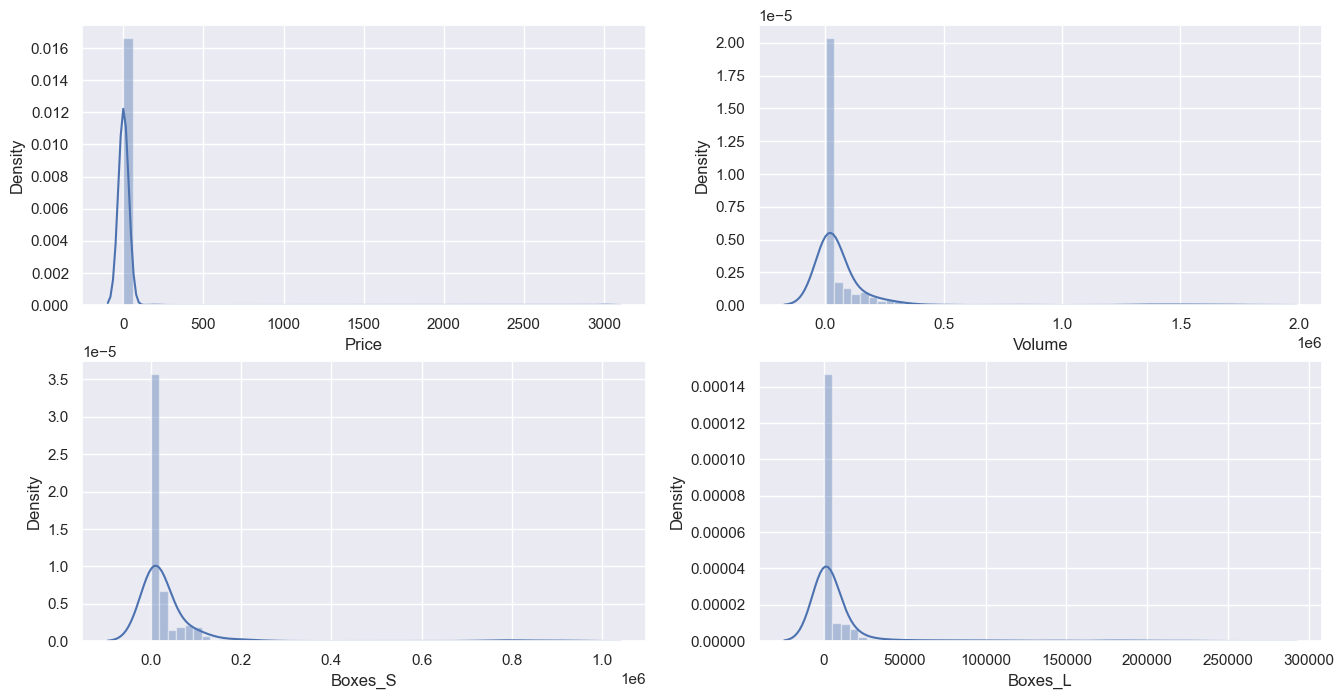

In [12]:
# Plot distribution
plt.figure(figsize=[16, 8])
plt.subplot(2,2,1)
sns.distplot(df['Price'])

plt.subplot(2,2,2)
sns.distplot(df['Volume'])

plt.subplot(2,2,3)
sns.distplot(df['Boxes_S'])

plt.subplot(2,2,4)
sns.distplot(df['Boxes_L'])

plt.show()

<Axes: xlabel='Boxes_L'>

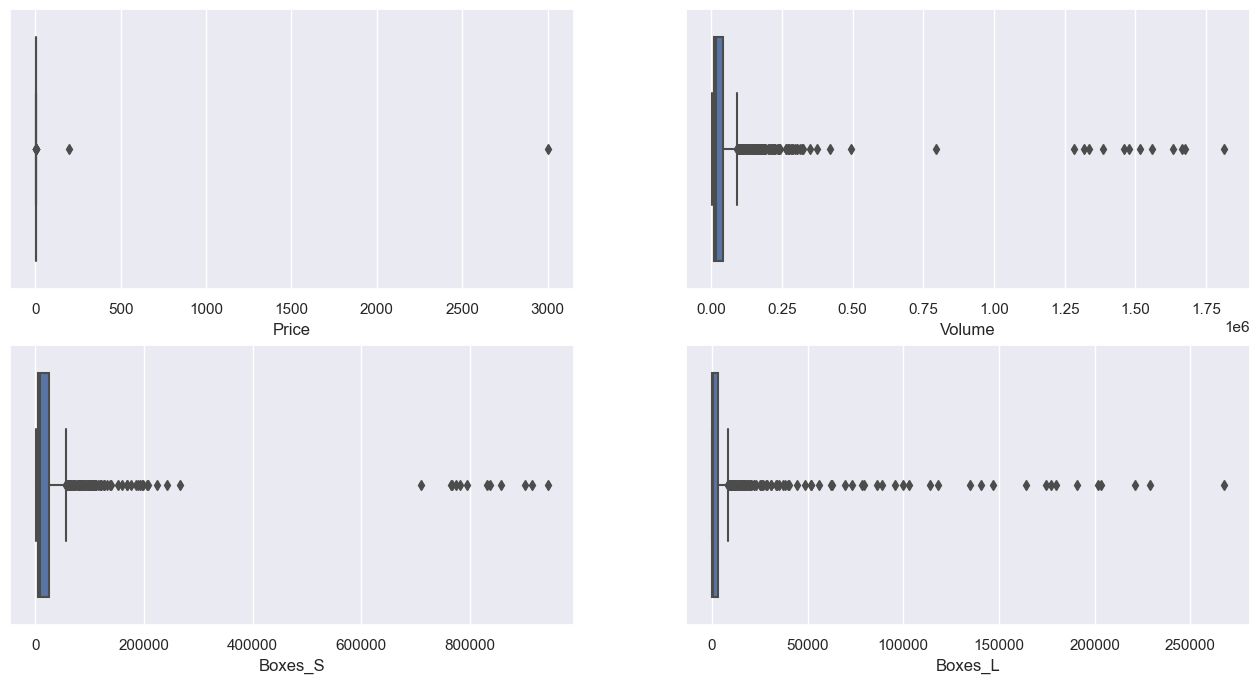

In [13]:
# Detecting outliers using boxplot
plt.figure(figsize=[16, 8])
plt.subplot(2,2,1)
sns.boxplot(x=df['Price'])

plt.subplot(2,2,2)
sns.boxplot(x=df['Volume'])

plt.subplot(2,2,3)
sns.boxplot(x=df['Boxes_S'])

plt.subplot(2,2,4)
sns.boxplot(x=df['Boxes_L'])

In [14]:
# As you can see in the plots above, the data is quite skewed.
# Try removing some outliers using the Interquartile Range (IQR) technique that is suitable for skewed data.
# sub_df = df[["Price", "Volume", "Boxes_T", "Boxes_S", "Boxes_L", "Boxes_XL"]]
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.30000000000000004


In [15]:
# Finding lower and upper limits
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

In [16]:
# Finding outliers
df[df['Price'] < lower_limit]

,Date,Price,Volume,Boxes_T,Boxes_S,Boxes_L,Boxes_XL,Region


In [17]:
# There are no outliers lower than the 25 percentile range. Focusing on the upper limit. 
df[df['Price'] > upper_limit]

,Date,Price,Volume,Boxes_T,Boxes_S,Boxes_L,Boxes_XL,Region
98,2018-03-11,199.00,41969.83,9003.70,8990.36,13.34,0.0,Daejon
451,2018-02-04,2.25,14635.63,9226.43,9000.42,226.01,0.0,Yangju
491,2018-01-07,2.18,6511.97,1746.67,1746.67,0.00,0.0,Donghae
509,2018-02-18,2.25,21551.76,2286.67,2283.34,3.33,0.0,Gyeongju
510,2018-02-11,2.22,21708.65,2533.33,2533.33,0.00,0.0,Gyeongju
512,2018-01-28,2.27,20325.75,2148.89,2148.89,0.00,0.0,Gyeongju
515,2018-01-07,2.30,20151.24,1943.34,1943.34,0.00,0.0,Gyeongju
575,2018-01-07,3003.00,3788.91,2162.34,600.00,1562.34,0.0,Gwangmyeong


In [18]:
# Trimming outliers
trim_df = df[df['Price'] < upper_limit]
trim_df.shape

(635, 8)

/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/1691850203.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df['Price'])
/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/1691850203.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=trim_df['Price'])


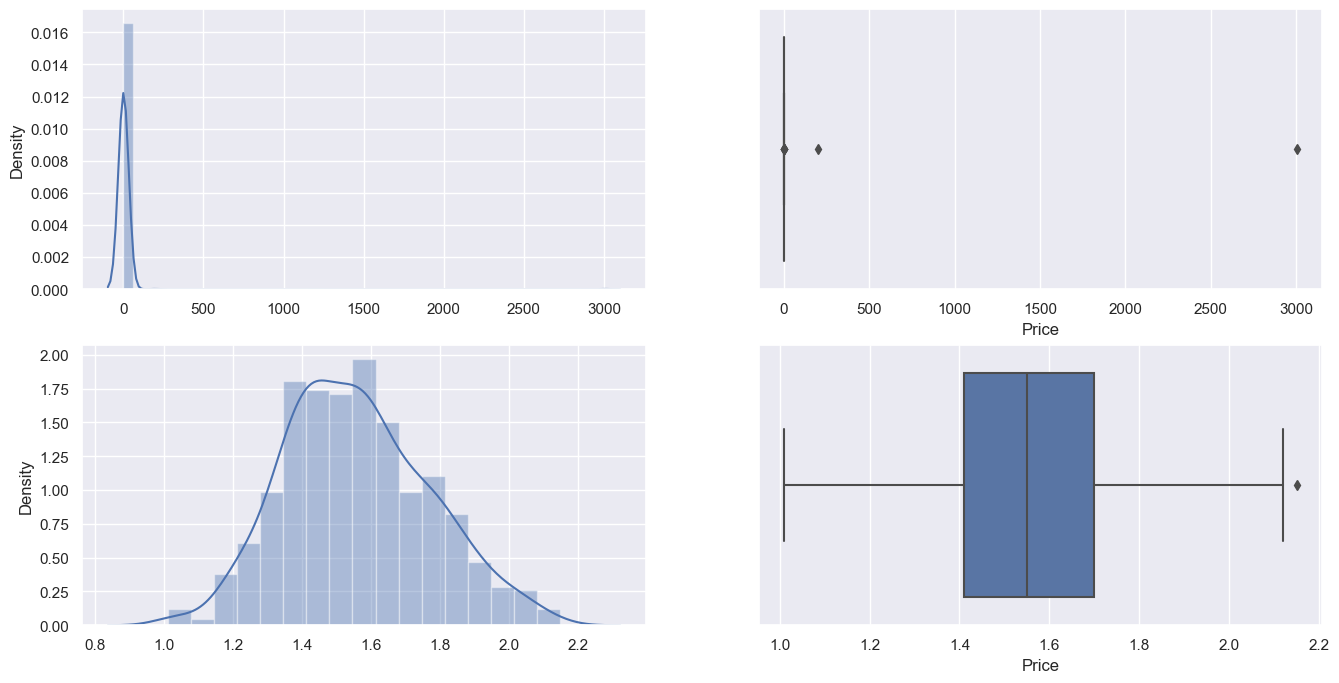

In [19]:
# Compare plots after trimming
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(x=df['Price'])
plt.subplot(2,2,2)
sns.boxplot(x=df['Price'])
plt.subplot(2,2,3)
sns.distplot(x=trim_df['Price'])
plt.subplot(2,2,4)
sns.boxplot(x=trim_df['Price'])
plt.show()

In [20]:
# Capping
df_cap = df.copy()
df_cap['Price'] = np.where(
    df_cap['Price'] > upper_limit,
    upper_limit,
    np.where(
        df_cap['Price'] < lower_limit,
        lower_limit,
        df_cap['Price']
    )
)

In [21]:
df_cap.shape

(644, 8)

/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/827624575.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df['Price'])
/var/folders/hx/jkrx942x4kz9hg6l_6g39_180000gp/T/ipykernel_5561/827624575.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_cap['Price'])


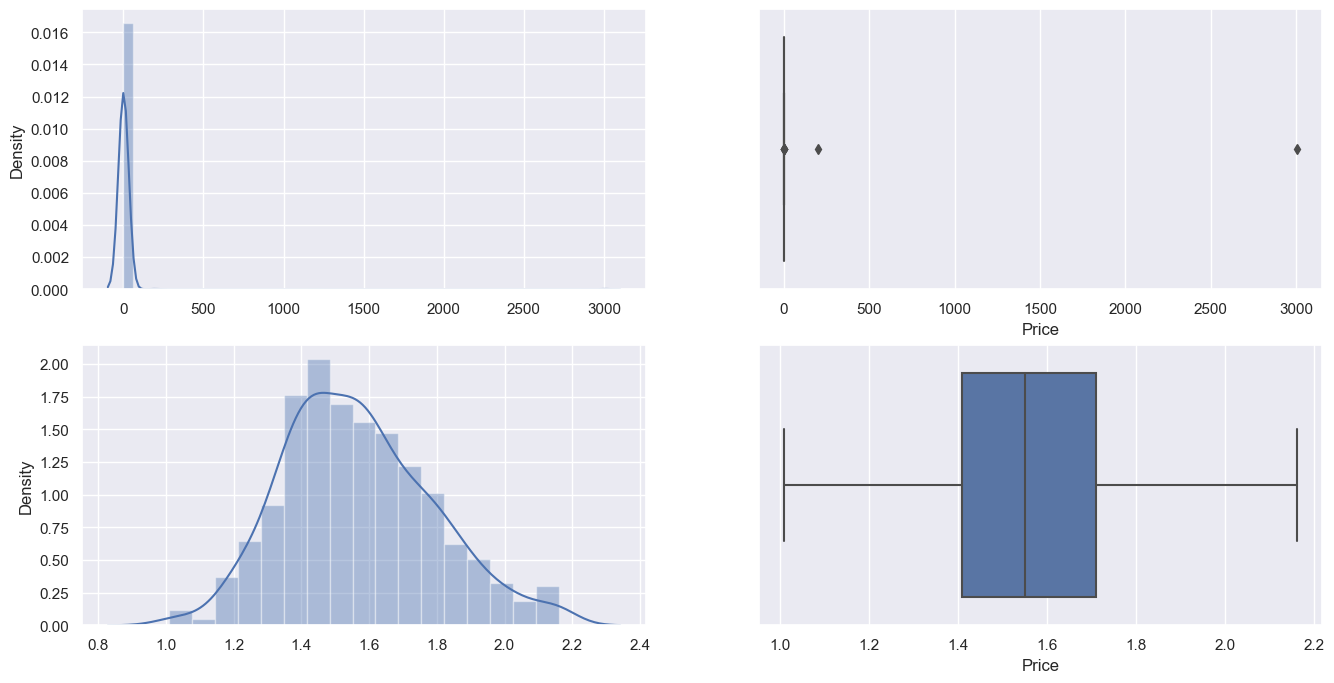

In [22]:
# Compare plots after capping
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(x=df['Price'])
plt.subplot(2,2,2)
sns.boxplot(x=df['Price'])
plt.subplot(2,2,3)
sns.distplot(x=df_cap['Price'])
plt.subplot(2,2,4)
sns.boxplot(x=df_cap['Price'])
plt.show()

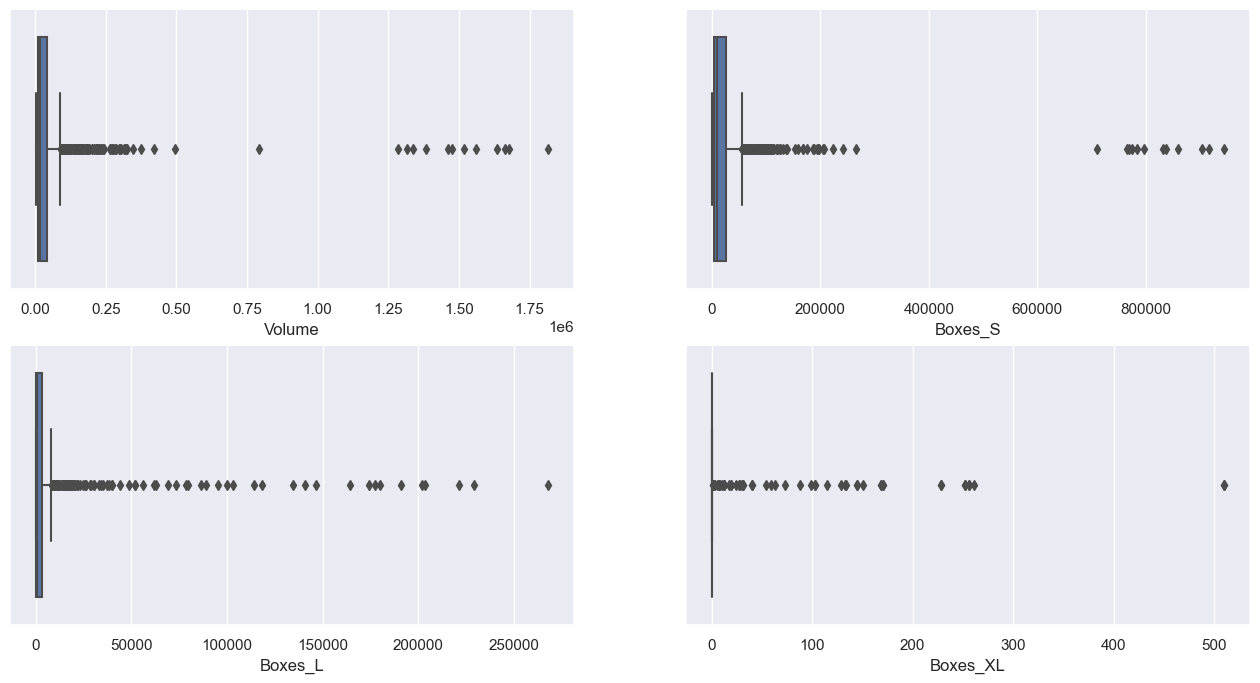

In [23]:
# Comparing other features
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.boxplot(x=df_cap['Volume'])
plt.subplot(2,2,2)
sns.boxplot(x=df_cap['Boxes_S'])
plt.subplot(2,2,3)
sns.boxplot(x=df_cap['Boxes_L'])
plt.subplot(2,2,4)
sns.boxplot(x=df_cap['Boxes_XL'])
plt.show()

Even though the other columns are also very skewed (right-skewed), I'll not trim or cap them because doing so will reduce the dataset size that is already quite small. 
There are 2 options here: 
1. Transform data to approximate normal distribution.
2. Use a Standard Scaler and don't fix skew.
2. Use tree based model for regression as they are not affected by skewed data.

For transformation, there are many options
1. log transformation
2. Normalize (min-max)
3. Cube root: used when values are too large. Can be applied to negative values.
4. Square root: Applied only to positive values.
5. Reciprocal
6. Square: apply on left skew (not this case)
7. Box Cox transformation
8. Quantile transform
9. Power transform

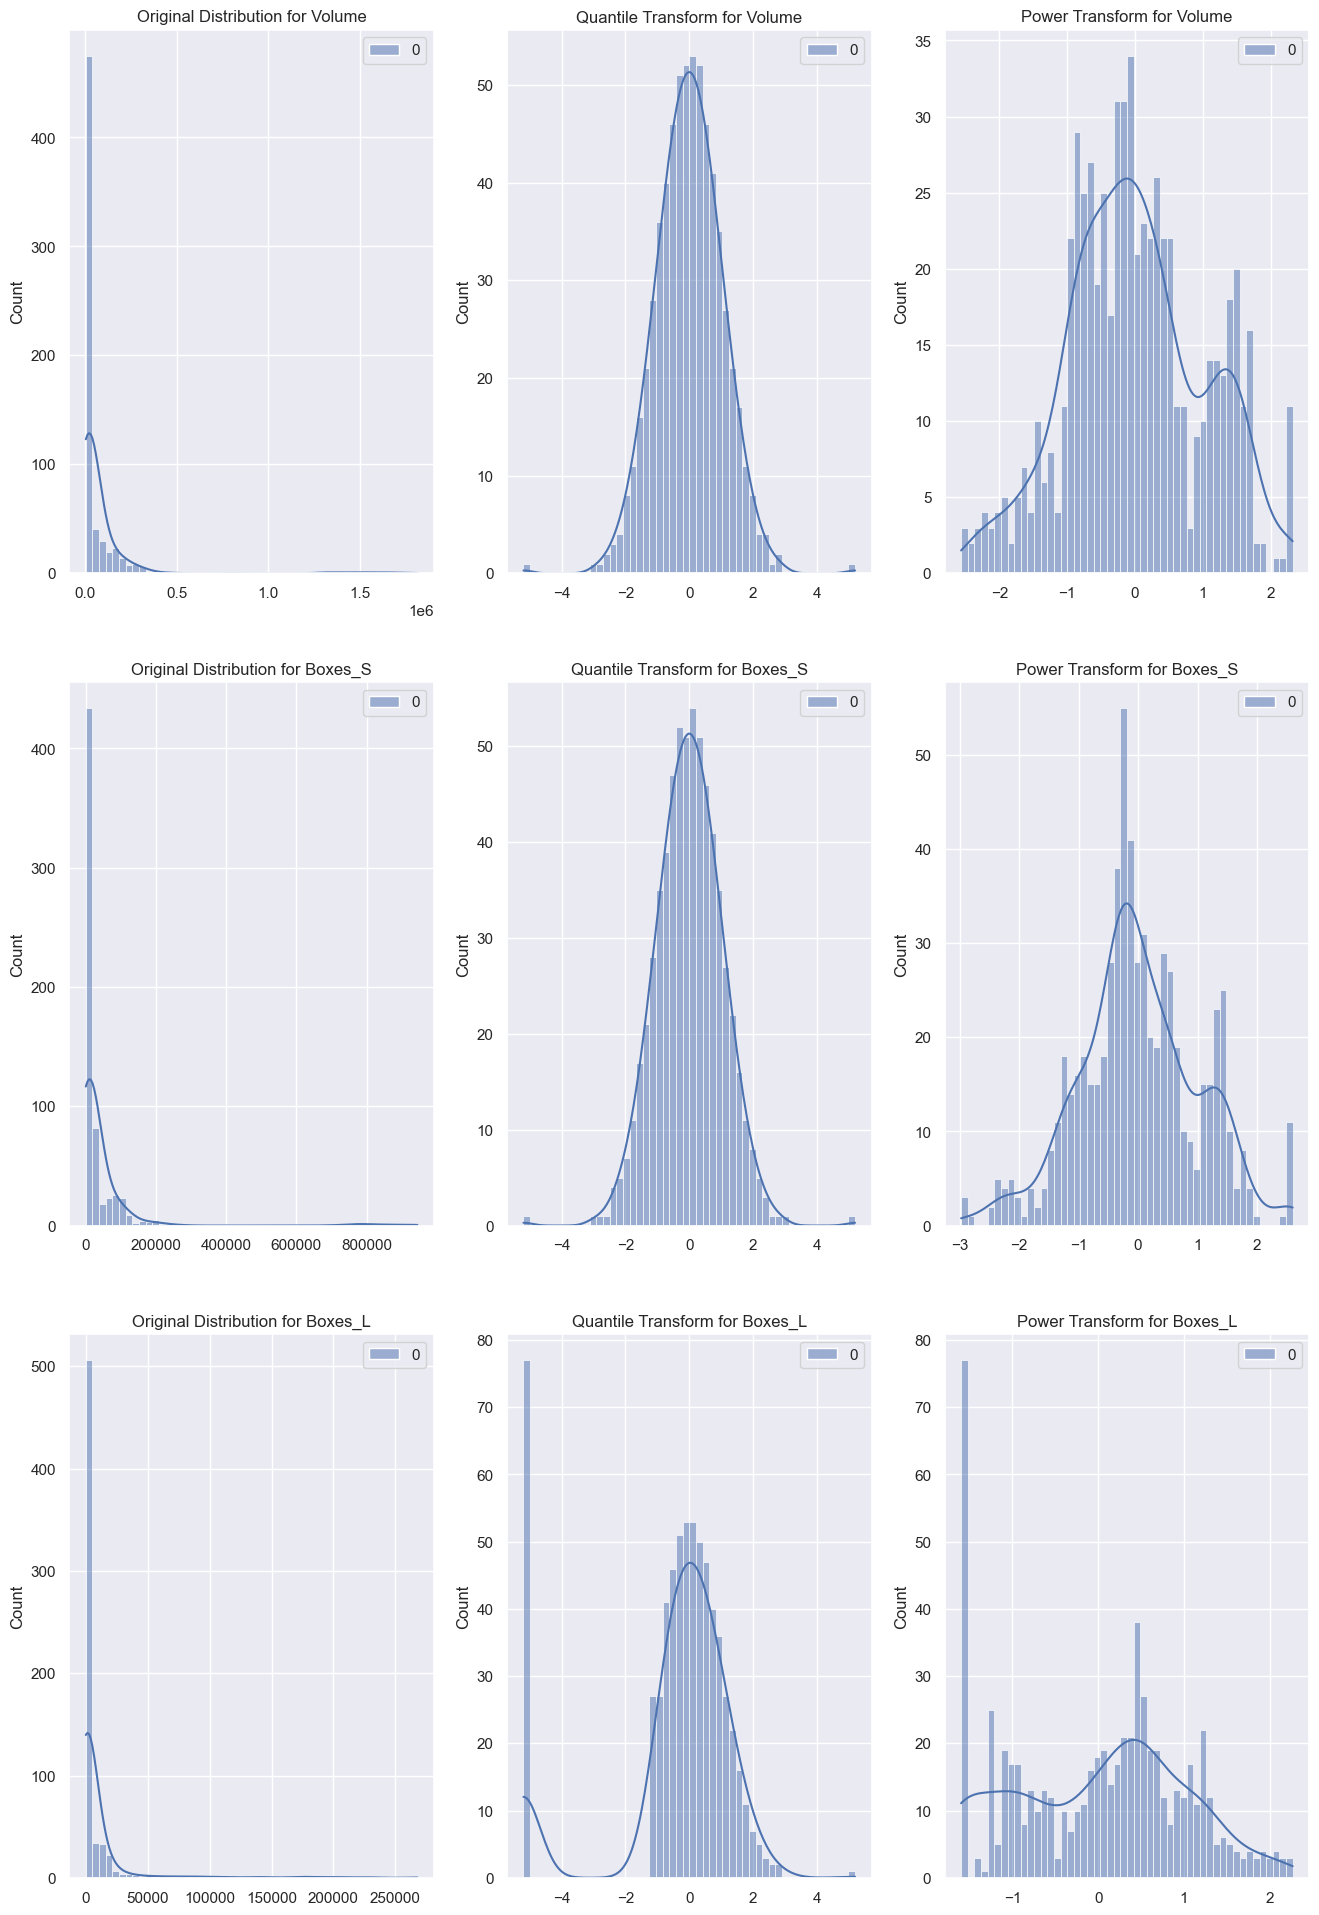

In [26]:
# Let's try Power transform and quantile transform
cols1 = ["Volume", "Boxes_S", "Boxes_L"]
def test_transformers(columns):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(16,24))
    j = 1
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        y = pt.fit_transform(array)
        x = qt.fit_transform(array)
        plt.subplot(3,3,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(3,3,j+1)
        sns.histplot(x, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        plt.subplot(3,3,j+2)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Power Transform for {i}")
        j += 3
test_transformers(cols1)

In [27]:
# Quantile Transform is able to normalize the data nicely so I will use that. Remember that the same preprocessing must be applied to new data later. 
# I'm dropping "Total Boxes" because it won't make sense here.
df = df.drop(["Boxes_T"], axis=1)
df.describe()


,Date,Price,Volume,Boxes_S,Boxes_L,Boxes_XL
count,644,644.000000,6.440000e+02,644.000000,644.000000,644.000000
mean,2018-02-14 11:28:41.739130368,6.533540,7.527630e+04,40821.660062,9082.506056,8.397205
min,2018-01-07 00:00:00,1.010000,2.064900e+03,284.430000,0.000000,0.000000
25%,2018-01-21 00:00:00,1.410000,9.181025e+03,4871.780000,14.322500,0.000000
50%,2018-02-14 12:00:00,1.550000,1.772473e+04,9136.225000,622.720000,0.000000
75%,2018-03-05 18:00:00,1.710000,4.158385e+04,25249.617500,3324.147500,0.000000
max,2018-03-25 00:00:00,3003.000000,1.814930e+06,944572.500000,267818.310000,510.410000
std,NaN,118.516792,2.132017e+05,115365.878676,29718.386287,43.433469


In [29]:
df_trans = df.copy()
cols2 = ["Volume", "Boxes_S", "Boxes_L", "Boxes_XL"]
def transform_columns(columns):
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        df_trans[i] = qt.fit_transform(array)
transform_columns(cols2)
df_trans.describe()

,Date,Price,Volume,Boxes_S,Boxes_L,Boxes_XL
count,644,644.000000,644.000000,644.000000,644.000000,644.000000
mean,2018-02-14 11:28:41.739130368,6.533540,-0.000010,-0.000189,-0.417902,-4.622255
min,2018-01-07 00:00:00,1.010000,-5.199338,-5.199338,-5.199338,-5.199338
25%,2018-01-21 00:00:00,1.410000,-0.674429,-0.675149,-0.673968,-5.199338
50%,2018-02-14 12:00:00,1.550000,0.000517,0.001008,-0.000403,-5.199338
75%,2018-03-05 18:00:00,1.710000,0.675354,0.674482,0.674772,-5.199338
max,2018-03-25 00:00:00,3003.000000,5.199338,5.199338,5.199338,5.199338
std,NaN,118.516792,1.032084,1.032811,1.934075,1.959516


In [30]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 644 entries, 0 to 647
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      644 non-null    datetime64[ns]
 1   Price     644 non-null    float64       
 2   Volume    644 non-null    float64       
 3   Boxes_S   644 non-null    float64       
 4   Boxes_L   644 non-null    float64       
 5   Boxes_XL  644 non-null    float64       
 6   Region    644 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 40.2+ KB


<Axes: title={'center': 'Region'}, xlabel='Region'>

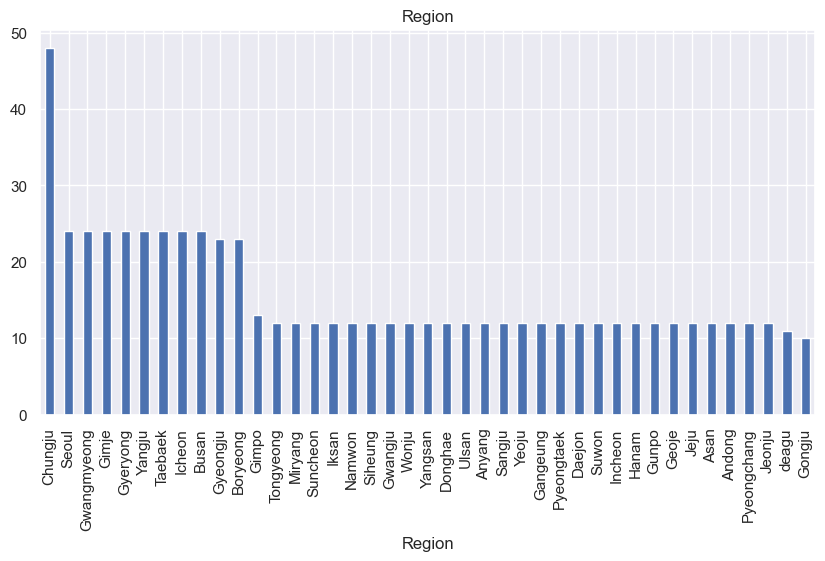

In [31]:
 # Histogram
plt.figure(figsize=[10, 5])
df_trans['Region'].value_counts().plot(kind="bar", title="Region")

In [32]:
# Convert date column into separate features
df_trans.Date = pd.to_datetime(df_trans.Date)
df_trans

,Date,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region
0,2018-03-25,1.71,-2.504629,-1.328080,-0.770705,-5.199338,Seoul
1,2018-03-18,1.66,-1.854711,-1.088027,-1.065669,-5.199338,Seoul
2,2018-03-11,1.68,-2.159678,-1.223057,-5.199338,-5.199338,Seoul
3,2018-03-04,1.48,-1.682854,-0.906856,-1.065669,-5.199338,Seoul
4,2018-02-25,1.56,-1.339511,-0.800765,-5.199338,-5.199338,Seoul
...,...,...,...,...,...,...,...
643,2018-02-04,1.63,-0.052204,0.258294,-0.098368,-5.199338,Boryeong
644,2018-01-28,1.71,-0.276743,-0.034715,-0.168663,-5.199338,Boryeong
645,2018-01-21,1.87,-0.293748,0.017565,-0.497850,-5.199338,Boryeong
646,2018-01-14,1.93,-0.093753,0.122859,-0.449173,-5.199338,Boryeong


In [33]:
df_trans["year"] = df_trans.Date.dt.year
df_trans["month"] = df_trans.Date.dt.month
df_trans["workingday"] = np.where(df_trans.Date.dt.dayofweek < 5, True, False)
df_trans["season"] = df_trans.apply(lambda x: 'winter' if x['month'] in [1,2,12] else ('spring' if x['month'] in [3,4,5] else ('summer' if x['month'] in [6,7,8] else 'autumm')), axis=1)
df_trans

,Date,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region,year,month,workingday,season
0,2018-03-25,1.71,-2.504629,-1.328080,-0.770705,-5.199338,Seoul,2018,3,False,spring
1,2018-03-18,1.66,-1.854711,-1.088027,-1.065669,-5.199338,Seoul,2018,3,False,spring
2,2018-03-11,1.68,-2.159678,-1.223057,-5.199338,-5.199338,Seoul,2018,3,False,spring
3,2018-03-04,1.48,-1.682854,-0.906856,-1.065669,-5.199338,Seoul,2018,3,False,spring
4,2018-02-25,1.56,-1.339511,-0.800765,-5.199338,-5.199338,Seoul,2018,2,False,winter
...,...,...,...,...,...,...,...,...,...,...,...
643,2018-02-04,1.63,-0.052204,0.258294,-0.098368,-5.199338,Boryeong,2018,2,False,winter
644,2018-01-28,1.71,-0.276743,-0.034715,-0.168663,-5.199338,Boryeong,2018,1,False,winter
645,2018-01-21,1.87,-0.293748,0.017565,-0.497850,-5.199338,Boryeong,2018,1,False,winter
646,2018-01-14,1.93,-0.093753,0.122859,-0.449173,-5.199338,Boryeong,2018,1,False,winter


In [34]:
df_trans.Date.dt.dayofweek.unique()

array([6], dtype=int32)

In [35]:
# All dates are Sundays and year is 2018, so I'll drop the columns.
df_trans = df_trans.drop(["workingday", "year", "Date"], axis=1)
df_trans

,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region,month,season
0,1.71,-2.504629,-1.328080,-0.770705,-5.199338,Seoul,3,spring
1,1.66,-1.854711,-1.088027,-1.065669,-5.199338,Seoul,3,spring
2,1.68,-2.159678,-1.223057,-5.199338,-5.199338,Seoul,3,spring
3,1.48,-1.682854,-0.906856,-1.065669,-5.199338,Seoul,3,spring
4,1.56,-1.339511,-0.800765,-5.199338,-5.199338,Seoul,2,winter
...,...,...,...,...,...,...,...,...
643,1.63,-0.052204,0.258294,-0.098368,-5.199338,Boryeong,2,winter
644,1.71,-0.276743,-0.034715,-0.168663,-5.199338,Boryeong,1,winter
645,1.87,-0.293748,0.017565,-0.497850,-5.199338,Boryeong,1,winter
646,1.93,-0.093753,0.122859,-0.449173,-5.199338,Boryeong,1,winter


,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,month
Price,1.000000,-0.063518,-0.080034,0.013901,-0.012220,-0.045042
Volume,-0.063518,1.000000,0.840624,0.261911,0.268134,0.057900
Boxes_S,-0.080034,0.840624,1.000000,0.184311,-0.015193,0.061329
Boxes_L,0.013901,0.261911,0.184311,1.000000,0.316779,0.085133
Boxes_XL,-0.012220,0.268134,-0.015193,0.316779,1.000000,-0.023169
month,-0.045042,0.057900,0.061329,0.085133,-0.023169,1.000000


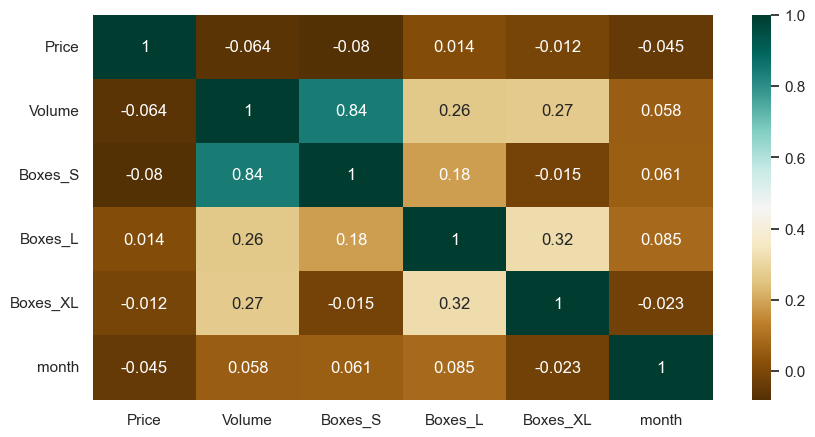

In [36]:
# Correlation plot
plt.figure(figsize=(10,5))
c = df_trans[["Price", "Volume", "Boxes_S", "Boxes_L", "Boxes_XL","month"]].corr()
sns.heatmap(c, cmap="BrBG", annot=True)
c

In [37]:
# Correlation between volume and Boxes_S, maybe most of the volume comes from small boxes.
# Price is slightly correlated to Boxes_XL.

<Axes: xlabel='Region', ylabel='Price'>

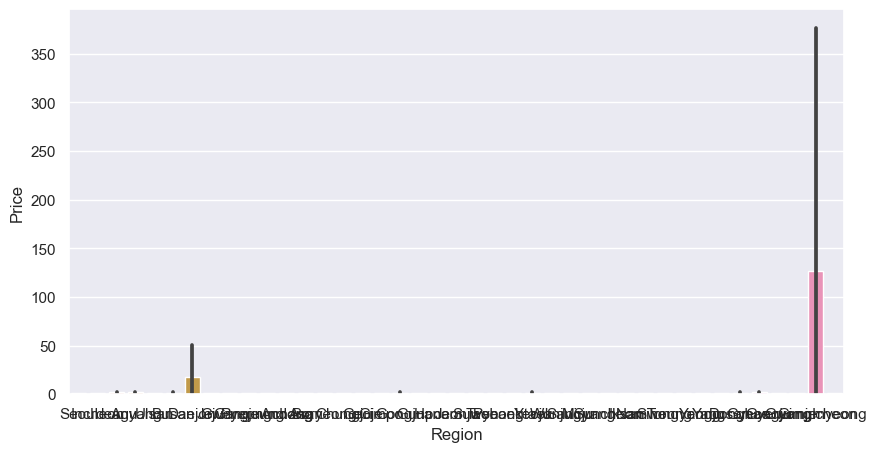

In [38]:
# Checking for correlation between region and price
plt.figure(figsize=(10,5))
sns.barplot(x=df_trans["Region"], y=df_trans["Price"])

# TRAINING

In [39]:
# The dataset has some categorical variables that need to be encoded.
# Nominal: Region
# Ordinal: Season

In [40]:
# Encoding ordinal variable "season"
df_trans["season"] = df_trans["season"].map({ "winter": 0, "spring": 1, "summer": 2, "autumm": 3})
df_trans

,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region,month,season
0,1.71,-2.504629,-1.328080,-0.770705,-5.199338,Seoul,3,1
1,1.66,-1.854711,-1.088027,-1.065669,-5.199338,Seoul,3,1
2,1.68,-2.159678,-1.223057,-5.199338,-5.199338,Seoul,3,1
3,1.48,-1.682854,-0.906856,-1.065669,-5.199338,Seoul,3,1
4,1.56,-1.339511,-0.800765,-5.199338,-5.199338,Seoul,2,0
...,...,...,...,...,...,...,...,...
643,1.63,-0.052204,0.258294,-0.098368,-5.199338,Boryeong,2,0
644,1.71,-0.276743,-0.034715,-0.168663,-5.199338,Boryeong,1,0
645,1.87,-0.293748,0.017565,-0.497850,-5.199338,Boryeong,1,0
646,1.93,-0.093753,0.122859,-0.449173,-5.199338,Boryeong,1,0


In [41]:
# Encoding nominal variabe "Region"
one_hot_enc = OneHotEncoder(sparse_output=False)

In [42]:
one_hot_enc.fit_transform(df_trans[["Region"]])

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
one_hot_enc.categories_

[array(['Andong', 'Anyang', 'Asan', 'Boryeong', 'Busan', 'Chungju',
        'Daejon', 'Donghae', 'Gangeung', 'Geoje', 'Gimje', 'Gimpo',
        'Gongju', 'Gunpo', 'Gwangju', 'Gwangmyeong', 'Gyeongju',
        'Gyeryong', 'Hanam', 'Icheon', 'Iksan', 'Incheon', 'Jeju',
        'Jeonju', 'Miryang', 'Namwon', 'Pyeongchang', 'Pyeongtaek',
        'Sangju', 'Seoul', 'Siheung', 'Suncheon', 'Suwon', 'Taebaek',
        'Tongyeong', 'Ulsan', 'Wonju', 'Yangju', 'Yangsan', 'Yeoju',
        'deagu'], dtype=object)]

In [44]:
# Spliting data into training and testing sets
X = df_trans.drop(["Price"], axis=1)
y = df_trans["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (515, 7)
y_train:  (515,)
X_test:  (129, 7)
y_test:  (129,)


In [45]:
# Make column transformer to make it easier to create scikit-learn pipeline later
# Encoding nominal variabe "Region"
one_hot_enc = OneHotEncoder(sparse_output=False)
col_trans = make_column_transformer((one_hot_enc, ["Region"]))

In [46]:
col_trans.fit_transform(X)[:5]

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
# Create pipelines from all 3 models

# Instantiate pipeline with linear regression
lm = LinearRegression()
lm_pipeline = make_pipeline(col_trans, lm)

# Instantiate Gradient Boosting Regressor with default loss = 'squared_error' and default criterion = 'friedman_mse'
gbm = GradientBoostingRegressor()
gbm_pipeline = make_pipeline(col_trans, gbm)

# Deault criterion for Random Forrest is 'squared_error'
rfm = RandomForestRegressor()
rfm_pipeline = make_pipeline(col_trans, rfm)

In [48]:
# Train models
lm_pipeline.fit(X_train, y_train)
lm_predictions = lm_pipeline.predict(X_test)
print("First 5 LM predictions: ", list(lm_predictions[:5]))

gbm_pipeline.fit(X_train, y_train)
gbm_predictions = gbm_pipeline.predict(X_test)
print("First 5 GBM predictions: ", list(gbm_predictions[:5]))

rfm_pipeline.fit(X_train, y_train)
rfm_predictions = rfm_pipeline.predict(X_test)
print("First 5 RFM predictions: ", list(rfm_predictions[:5]))

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


First 5 LM predictions:  [1.49609375, 1.7890625, 1.587890625, 1.453125, 1.458984375]
First 5 GBM predictions:  [1.570234108748342, 1.684092973470151, 1.570234108748342, 1.5364976712655778, 1.4950548796223968]
First 5 RFM predictions:  [1.5008403596532467, 1.7809880916305927, 1.576117186098216, 1.4529830472597585, 1.4340915504736238]


In [49]:
y_test[:5]

145    1.67
242    1.53
470    1.54
299    1.47
551    1.41
Name: Price, dtype: float64

In [50]:
# Calculate mean absolute error (MAE) and root mean squared error (RMSE)

lm_mae = mean_absolute_error(y_true=y_test, y_pred=lm_predictions)
lm_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lm_predictions))
print(f"LM MAE: {round(lm_mae, 2)}")
print(f"LM RMSE: {round(lm_rmse, 2)}")

gbm_mae = mean_absolute_error(y_true=y_test, y_pred=gbm_predictions)
gbm_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=gbm_predictions))
print(f"GBM MAE: {round(gbm_mae, 2)}")
print(f"GBM RMSE: {round(gbm_rmse, 2)}")

rfm_mae = mean_absolute_error(y_true=y_test, y_pred=rfm_predictions)
rfm_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rfm_predictions))
print(f"RFM MAE: {round(rfm_mae, 2)}")
print(f"RFM RMSE: {round(rfm_rmse, 2)}")

LM MAE: 10.21
LM RMSE: 41.27
GBM MAE: 10.21
GBM RMSE: 41.25
RFM MAE: 11.42
RFM RMSE: 46.19


## More streamlined approach

In [51]:
# Convert date column into separate features
df.Date = pd.to_datetime(df.Date)
df

,Date,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region
0,2018-03-25,1.71,2321.82,1996.46,10.00,0.0,Seoul
1,2018-03-18,1.66,3154.45,2577.27,3.33,0.0,Seoul
2,2018-03-11,1.68,2570.52,2209.29,0.00,0.0,Seoul
3,2018-03-04,1.48,3851.30,3239.65,3.33,0.0,Seoul
4,2018-02-25,1.56,5356.63,4007.48,0.00,0.0,Seoul
...,...,...,...,...,...,...,...
643,2018-02-04,1.63,17074.83,13066.82,431.85,0.0,Boryeong
644,2018-01-28,1.71,13888.04,8940.04,324.80,0.0,Boryeong
645,2018-01-21,1.87,13766.76,9351.80,42.31,0.0,Boryeong
646,2018-01-14,1.93,16205.22,10919.54,50.00,0.0,Boryeong


In [53]:
df["month"] = df.Date.dt.month
df["season"] = df.apply(lambda x: 0 if x['month'] in [1,2,12] else (1 if x['month'] in [3,4,5] else (2 if x['month'] in [6,7,8] else 4)), axis=1)
df = df.drop(["Date"], axis=1)
df

,Price,Volume,Boxes_S,Boxes_L,Boxes_XL,Region,month,season
0,1.71,2321.82,1996.46,10.00,0.0,Seoul,3,1
1,1.66,3154.45,2577.27,3.33,0.0,Seoul,3,1
2,1.68,2570.52,2209.29,0.00,0.0,Seoul,3,1
3,1.48,3851.30,3239.65,3.33,0.0,Seoul,3,1
4,1.56,5356.63,4007.48,0.00,0.0,Seoul,2,0
...,...,...,...,...,...,...,...,...
643,1.63,17074.83,13066.82,431.85,0.0,Boryeong,2,0
644,1.71,13888.04,8940.04,324.80,0.0,Boryeong,1,0
645,1.87,13766.76,9351.80,42.31,0.0,Boryeong,1,0
646,1.93,16205.22,10919.54,50.00,0.0,Boryeong,1,0


In [54]:
# Spliting data into training and testing sets
X = df.drop(["Price"], axis=1)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (515, 7)
y_train:  (515,)
X_test:  (129, 7)
y_test:  (129,)


In [55]:
def run_model(model_name, pipeline, X_train, y_train, X_test, y_test):
    # Train model
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mae = mean_absolute_error(y_true=y_test, y_pred=predictions)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions))
    print(f"{model_name} MAE: {round(mae, 2)}")
    print(f"{model_name} RMSE: {round(rmse, 2)}")
    return round(rmse, 2)

def run_models(models, X_train, y_train, X_test, y_test):
    mae = []
    rmse = []
    names = []
    for item in models:
        pipeline = item["pipeline"]
        names.append(item["name"])
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        mae.append(mean_absolute_error(y_true=y_test, y_pred=predictions))
        rmse.append(np.sqrt(mean_squared_error(y_true=y_test, y_pred=predictions)))
    col={"MAE": mae, "RMSE": rmse}
    ret_df = pd.DataFrame(data=col, index=names)
    return ret_df


### USING STANDARD SCALER

In [56]:
# One hot encoding to encode nominal variabe "Region"
one_hot_enc = OneHotEncoder(sparse_output=False)

# Scale other numerical features with a StandardScaler
scaler = StandardScaler()

# Make column transformer to make it easier to create scikit-learn pipeline later
col_trans = make_column_transformer((one_hot_enc, ["Region"]), (scaler, ["Volume", "Boxes_S", "Boxes_L", "Boxes_XL"]))
col_trans.fit_transform(X)[:5]

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.34245123, -0.33680131, -0.30551989, -0.19348517],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

In [57]:
# Create pipelines from all models

models = []

# Instantiate pipeline with linear regression
lm = LinearRegression()
lm_pipeline = make_pipeline(col_trans, lm)
models.append({"name": "LinearReg", "pipeline": lm_pipeline})

# Instantiate Gradient Boosting Regressor with default loss = 'squared_error' and default criterion = 'friedman_mse'
gbm = GradientBoostingRegressor()
gbm_pipeline = make_pipeline(col_trans, gbm)
models.append({"name": "GradBoost", "pipeline": gbm_pipeline})

# Deault criterion for Random Forrest is 'squared_error'
rfm = RandomForestRegressor()
rfm_pipeline = make_pipeline(col_trans, rfm)
models.append({"name": "RandFor", "pipeline": rfm_pipeline})

# Decision Tree
dtm = tree.DecisionTreeRegressor(max_depth=1)
dtm_pipeline = make_pipeline(col_trans, dtm)
models.append({"name": "DecTree", "pipeline": dtm_pipeline})

# KNN
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_pipeline = make_pipeline(col_trans, knn)
models.append({"name": "KNN", "pipeline": knn_pipeline})

# SVM
svm = SVR()
svm_pipeline = make_pipeline(col_trans, svm)
# run_model("SVM", svm_pipeline, X_train, y_train, X_test, y_test)
models.append({"name": "SVM", "pipeline": svm_pipeline})

results = run_models(models, X_train, y_train, X_test, y_test)
results

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sk

,MAE,RMSE
LinearReg,10.342081,41.274891
GradBoost,46.821048,373.294027
RandFor,33.475812,229.319803
DecTree,7.421035,45.788963
KNN,5.667163,53.195512
SVM,0.117898,0.160601


### USING QUANTILE TRANSFORMER

In [58]:
# Encoding nominal variabe "Region"
one_hot_enc = OneHotEncoder(sparse_output=False)

# Normalize other numerical features with QuantileTransformer
quant_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal')

# Make column transformer to make it easier to create scikit-learn pipeline
col_trans = make_column_transformer((one_hot_enc, ["Region"]), (quant_trans, ["Volume", "Boxes_S", "Boxes_L", "Boxes_XL"]))
col_trans.fit_transform(X)[:5]

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -2.50462887, -1.32807964, -0.77070507, -5.19933758],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

In [59]:
# Create pipelines from all models

models = []

# Instantiate pipeline with linear regression
lm = LinearRegression()
lm_pipeline = make_pipeline(col_trans, lm)
models.append({"name": "LinearReg", "pipeline": lm_pipeline})

# Instantiate Gradient Boosting Regressor with default loss = 'squared_error' and default criterion = 'friedman_mse'
gbm = GradientBoostingRegressor()
gbm_pipeline = make_pipeline(col_trans, gbm)
models.append({"name": "GradBoost", "pipeline": gbm_pipeline})

# Deault criterion for Random Forrest is 'squared_error'
rfm = RandomForestRegressor()
rfm_pipeline = make_pipeline(col_trans, rfm)
models.append({"name": "RandFor", "pipeline": rfm_pipeline})

# Decision Tree
dtm = tree.DecisionTreeRegressor(max_depth=1)
dtm_pipeline = make_pipeline(col_trans, dtm)
models.append({"name": "DecTree", "pipeline": dtm_pipeline})

# KNN
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
knn_pipeline = make_pipeline(col_trans, knn)
models.append({"name": "KNN", "pipeline": knn_pipeline})

# SVM default kernel is RBF
svm = SVR()
svm_pipeline = make_pipeline(col_trans, svm)
# run_model("SVM", svm_pipeline, X_train, y_train, X_test, y_test)
models.append({"name": "SVM", "pipeline": svm_pipeline})

results = run_models(models, X_train, y_train, X_test, y_test)
results

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sk

,MAE,RMSE
LinearReg,16.655392,43.831407
GradBoost,46.809843,373.293906
RandFor,32.686742,227.641145
DecTree,7.421035,45.788963
KNN,14.366465,91.609868
SVM,0.121549,0.165607


In [60]:
# Final test
svm = SVR()
svm_pipeline = make_pipeline(col_trans, svm)
svm_pipeline.fit(X_train, y_train)
predictions = svm_pipeline.predict(X_test)
predictions[:5]

/Users/mattmiranda/Documents/ml-regression/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([1.55018023, 1.72350449, 1.59623759, 1.49601246, 1.45001254])

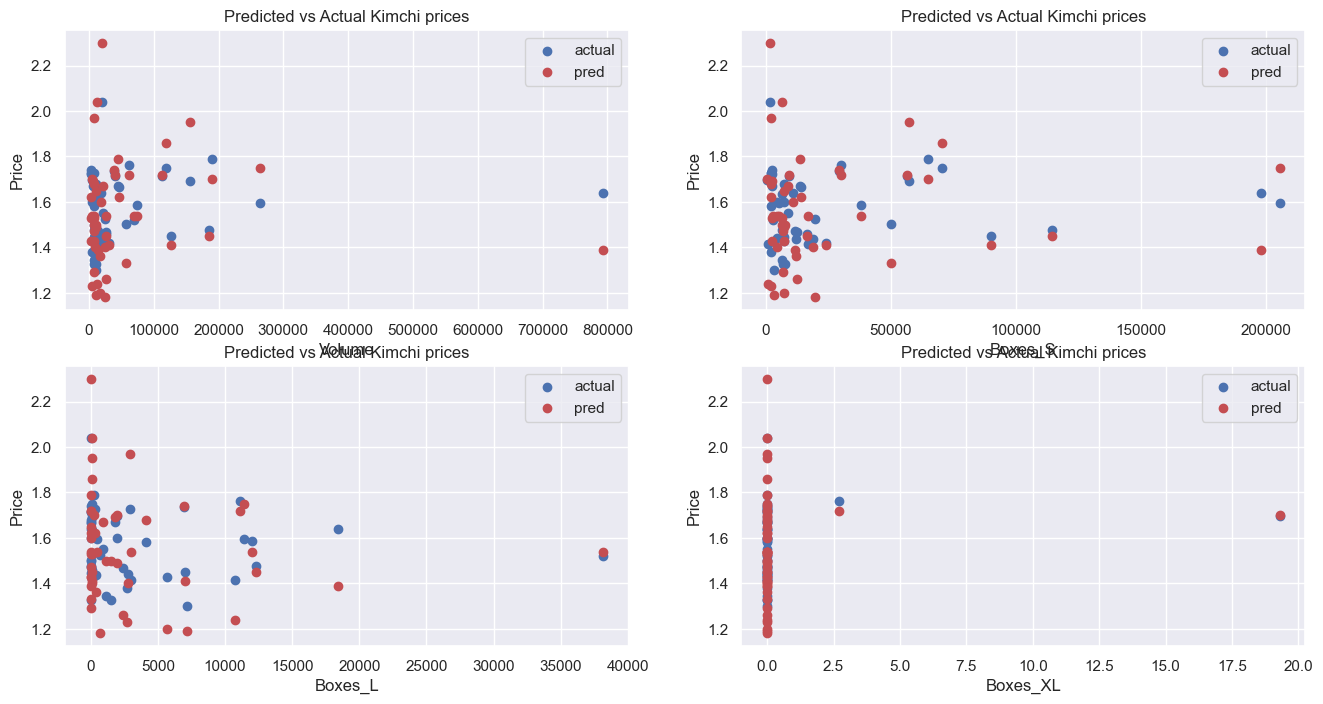

In [71]:
# Simple plot to see how the SVM model performed
y_pred = predictions[:50]

plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
X_plot = X_test["Volume"][:50]
plt.scatter(X_plot, y_pred, c='b', label='actual')
plt.scatter(X_plot, y_test[:50], c='r', label='pred')
plt.title("Predicted vs Actual Kimchi prices")
plt.xlabel("Volume")
plt.ylabel("Price")
plt.legend()

plt.subplot(2,2,2)
X_plot = X_test["Boxes_S"][:50]
plt.scatter(X_plot, y_pred, c='b', label='actual')
plt.scatter(X_plot, y_test[:50], c='r', label='pred')
plt.title("Predicted vs Actual Kimchi prices")
plt.xlabel("Boxes_S")
plt.ylabel("Price")
plt.legend()

plt.subplot(2,2,3)
X_plot = X_test["Boxes_L"][:50]
plt.scatter(X_plot, y_pred, c='b', label='actual')
plt.scatter(X_plot, y_test[:50], c='r', label='pred')
plt.title("Predicted vs Actual Kimchi prices")
plt.xlabel("Boxes_L")
plt.ylabel("Price")
plt.legend()

plt.subplot(2,2,4)
X_plot = X_test["Boxes_XL"][:50]
plt.scatter(X_plot, y_pred, c='b', label='actual')
plt.scatter(X_plot, y_test[:50], c='r', label='pred')
plt.title("Predicted vs Actual Kimchi prices")
plt.xlabel("Boxes_XL")
plt.ylabel("Price")
plt.legend()
